# Fashion-MNIST Classification using Neural Network

In this notebook, we'll build a neural network to classify Fashion-MNIST images

In [1]:
#Importing main libraries
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from collections import OrderedDict

C:\Users\mosta\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Module

In [2]:
import pytorch_lightning as pl
from torchvision import transforms, datasets
from torchmetrics import Accuracy
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from pytorch_lightning.loggers import CSVLogger


class FashionMNISTDataModule(pl.LightningDataModule):
    def __init__(self, data_dir: str = './'):
        super().__init__()
        self.data_dir = data_dir

    def prepare_data(self):
        # download the dataset if it does not exist
        datasets.FashionMNIST(self.data_dir, train=True, download=True)
        datasets.FashionMNIST(self.data_dir, train=False, download=True)

    def setup(self, stage=None):
        # define transforms
        transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
        
        if stage == 'fit' or stage is None:
            self.train_dataset = datasets.FashionMNIST('F_MNIST_data', download=True, train=True, transform=transform)
            train_num = len(self.train_dataset)
            indices = list(range(train_num))
            np.random.shuffle(indices)
            split = int(np.floor(0.2 * train_num))
            self.val_idx, self.train_idx = indices[:split], indices[split:]
            

        if stage == 'test' or stage is None:
            self.test_dataset = datasets.FashionMNIST(self.data_dir, download=True, train=False, transform=transform)

    def train_dataloader(self):
        train_sampler = torch.utils.data.sampler.SubsetRandomSampler(self.train_idx)
        train_dl = torch.utils.data.DataLoader(self.train_dataset, batch_size=64, sampler=train_sampler)
        return train_dl
    
    def val_dataloader(self):
        val_sampler = torch.utils.data.sampler.SubsetRandomSampler(self.val_idx)
        val_dl = torch.utils.data.DataLoader(self.train_dataset, batch_size=64, sampler=val_sampler)
        return val_dl
    
    def test_dataloader(self):
        test_dl = torch.utils.data.DataLoader(self.test_dataset, batch_size=64, shuffle=True)
        return test_dl

## Lightning Module

In [3]:
class FashionMNISTDataClassifier(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(OrderedDict([('fc1', nn.Linear(784, 128)),
                                                ('relu1', nn.ReLU()),
                                                ('drop1', nn.Dropout(0.25)),
                                                ('fc2', nn.Linear(128, 64)),
                                                ('relu2', nn.ReLU()),
                                                ('drop1', nn.Dropout(0.25)),
                                                ('output', nn.Linear(64, 10)),
                                                ('logsoftmax', nn.LogSoftmax(dim=1))]))
        self.loss_fn = nn.NLLLoss()

        self.train_losses =[]
        self.test_losses = []

        self.val_accuracy = Accuracy(task='multiclass', num_classes=10)
        self.test_accuracy = Accuracy(task='multiclass', num_classes=10)

        #Will be used for storing the losses after each step
        #TODO: It is better to get the losses from the trainer instead of storing them here
        self.temp_training_losses = []
        self.temp_validation_losses = []

        
    def forward(self, x):
        x = self.network(x)
        return x
    
    def training_step(self, batch, batch_idx):
        images, labels = batch
        images = images.view(images.shape[0], -1)
        out = self.forward(images)
        loss = self.loss_fn(out, labels)
        self.log('train_loss', loss, prog_bar=True)
        self.temp_training_losses.append(loss)
    
    def validation_step(self, batch, batch_idx):
        images, labels = batch
        images = images.view(images.shape[0], -1)
        out = self.forward(images)
        loss = self.loss_fn(out, labels)
        preds = torch.argmax(out, dim=1)
        self.val_accuracy.update(preds, labels)

        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', self.val_accuracy, prog_bar=True)

        self.temp_validation_losses.append(loss)
    
    def test_step(self, batch, batch_idx):
        images, labels = batch
        images = images.view(images.shape[0], -1)
        out = self.forward(images)
        loss = self.loss_fn(out, labels)
        preds = torch.argmax(out, dim=1)
        self.test_accuracy.update(preds, labels)
        
        self.log('test_loss', loss, prog_bar=True)
        self.log('test_acc', self.test_accuracy, prog_bar=True)
    
    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=0.003)
        return optimizer
    
    def on_train_epoch_end(self, *args, **kwargs):        
        train_loss_mean = torch.stack(self.temp_training_losses).mean()
        self.temp_training_losses = []
        self.train_losses.append(train_loss_mean)


    def on_validation_epoch_end(self, *arg, **kwargs):
        val_loss_mean = torch.stack(self.temp_validation_losses).mean()
        self.temp_validation_losses = []
        self.test_losses.append(val_loss_mean)

    def plot_losses(self):
        train_losses_tensor = torch.tensor(self.train_losses, dtype=torch.float32)
        test_losses_tensor = torch.tensor(self.test_losses, dtype=torch.float32)
        
        plt.plot(train_losses_tensor.detach().numpy(), label='train-loss')
        plt.plot(test_losses_tensor.detach().numpy(), label='val-loss')
        plt.legend()
        plt.show()

In [4]:
#Initializing the data module and the model
dm = FashionMNISTDataModule()
model = FashionMNISTDataClassifier()

print(model)

FashionMNISTDataClassifier(
  (network): Sequential(
    (fc1): Linear(in_features=784, out_features=128, bias=True)
    (relu1): ReLU()
    (drop1): Dropout(p=0.25, inplace=False)
    (fc2): Linear(in_features=128, out_features=64, bias=True)
    (relu2): ReLU()
    (output): Linear(in_features=64, out_features=10, bias=True)
    (logsoftmax): LogSoftmax(dim=1)
  )
  (loss_fn): NLLLoss()
  (val_accuracy): MulticlassAccuracy()
  (test_accuracy): MulticlassAccuracy()
)


## Train the network

In [5]:
trainer = None
def train_validate(model, n_epochs):
    trainer = pl.Trainer(max_epochs=n_epochs, callbacks=[TQDMProgressBar(refresh_rate=20)],
    logger=CSVLogger(save_dir="logs/"))

    #Training
    trainer.fit(model, dm)

    #Printing the losses
    model.plot_losses()

In [6]:
# Train and validate
train_validate(model, n_epochs=25)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\mosta\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:612: UserWarning: Checkpoint directory logs/lightning_logs\version_0\checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name          | Type               | Params
-----------------------------------------------------
0 | network       | Sequential         | 109 K 
1 | loss_fn       | NLLLoss            | 0     
2 | val_accuracy  | MulticlassAccuracy | 0     
3 | test_accuracy | MulticlassAccuracy | 0     
-----------------------------------------------------
109 K     Trainable params
0         Non-trainable params
109 K     Total params
0.438     Total estimated model params size (MB)
C:\U

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

C:\Users\mosta\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


C:\Users\mosta\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0:   0%|          | 0/750 [00:00<?, ?it/s] 

C:\Users\mosta\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pytorch_lightning\loops\optimization\automatic.py:129: UserWarning: `training_step` returned `None`. If this was on purpose, ignore this warning...
  self.warning_cache.warn("`training_step` returned `None`. If this was on purpose, ignore this warning...")


Epoch 4:  59%|█████▊    | 440/750 [00:08<00:06, 51.25it/s, v_num=0, train_loss=2.330, val_loss=2.320, val_acc=0.0797]

PermissionError: [Errno 13] Permission denied: 'c:/Users/mosta/OneDrive/Documents/AI & Data science/fashion-mnist-classification/logs/lightning_logs/version_0/hparams.yaml'

### Predict a single image

In [23]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

index = 0
img, label = dm.test_dataset[index]

label = torch.tensor(label) if not isinstance(label, torch.Tensor) else label

img = img.view(-1, 28*28)

# Calculate the class probabilities (softmax) for img
proba = torch.exp(model(img.unsqueeze(0)))

# Plot the image and probabilities
desc = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot']
fig, (ax1, ax2) =  plt.subplots(figsize=(13, 6), nrows=1, ncols=2)
ax1.axis('off')
ax1.imshow(img.squeeze().reshape(28, 28))
ax1.set_title(desc[label.item()])
ax2.bar(range(10), proba.detach().cpu().numpy().squeeze())
ax2.set_xticks(range(10))
ax2.set_xticklabels(desc, size='small')
ax2.set_title('Predicted Probabilities')
plt.tight_layout()

AttributeError: 'FashionMNISTDataModule' object has no attribute 'test_dataset'

## Validate on test set

In [ ]:
# Validate
trainer.test(model, datamodule=dm)

Missing logger folder: logs/lightning_logs
C:\Users\mosta\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:478: PossibleUserWarning: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
C:\Users\mosta\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 157/157 [00:02<00:00, 59.34it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.09350000321865082
        test_loss            2.311596393585205
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 2.311596393585205, 'test_acc': 0.09350000321865082}]

## More powerful model

In [20]:
# Redefine network with dropout layers in between
model.network = nn.Sequential(OrderedDict([('fc1', nn.Linear(784, 392)),
                                       ('relu1', nn.ReLU()),
                                       ('drop1', nn.Dropout(0.25)),
                                       ('fc12', nn.Linear(392, 196)),
                                       ('relu2', nn.ReLU()),
                                       ('drop2', nn.Dropout(0.25)),
                                       ('fc3', nn.Linear(196, 98)),
                                       ('relu3', nn.ReLU()),
                                       ('drop3', nn.Dropout(0.25)),                                       
                                       ('fc4', nn.Linear(98, 49)),
                                       ('relu4', nn.ReLU()),
                                       ('output', nn.Linear(49, 10)),
                                       ('logsoftmax', nn.LogSoftmax(dim=1))]))

In [21]:
model

Sequential(
  (fc1): Linear(in_features=784, out_features=392, bias=True)
  (relu1): ReLU()
  (drop1): Dropout(p=0.25, inplace=False)
  (fc12): Linear(in_features=392, out_features=196, bias=True)
  (relu2): ReLU()
  (drop2): Dropout(p=0.25, inplace=False)
  (fc3): Linear(in_features=196, out_features=98, bias=True)
  (relu3): ReLU()
  (drop3): Dropout(p=0.25, inplace=False)
  (fc4): Linear(in_features=98, out_features=49, bias=True)
  (relu4): ReLU()
  (output): Linear(in_features=49, out_features=10, bias=True)
  (logsoftmax): LogSoftmax(dim=1)
)

Epoch: 0 -> train_loss: 0.6855045186281204517, val_loss: 0.4465020298957824707,  val_acc: 84.07%
Epoch: 1 -> train_loss: 0.4642426335414250871, val_loss: 0.4065601229667663574,  val_acc: 85.46%
Epoch: 2 -> train_loss: 0.4183805910150210083, val_loss: 0.3935156464576721191,  val_acc: 85.79%
Epoch: 3 -> train_loss: 0.3921241991321245957, val_loss: 0.3722155690193176270,  val_acc: 86.65%
Epoch: 4 -> train_loss: 0.3697275487581888620, val_loss: 0.3648492991924285889,  val_acc: 86.98%
Epoch: 5 -> train_loss: 0.3555079794029394891, val_loss: 0.3529390692710876465,  val_acc: 86.83%
Epoch: 6 -> train_loss: 0.3443926275670528558, val_loss: 0.3248184919357299805,  val_acc: 88.38%
Epoch: 7 -> train_loss: 0.3269262994229793495, val_loss: 0.3249777853488922119,  val_acc: 88.48%
Epoch: 8 -> train_loss: 0.3205269113381703505, val_loss: 0.3181797266006469727,  val_acc: 88.50%
Epoch: 9 -> train_loss: 0.3130609797338644862, val_loss: 0.3347418010234832764,  val_acc: 87.97%
Epoch: 10 -> train_loss: 0.301

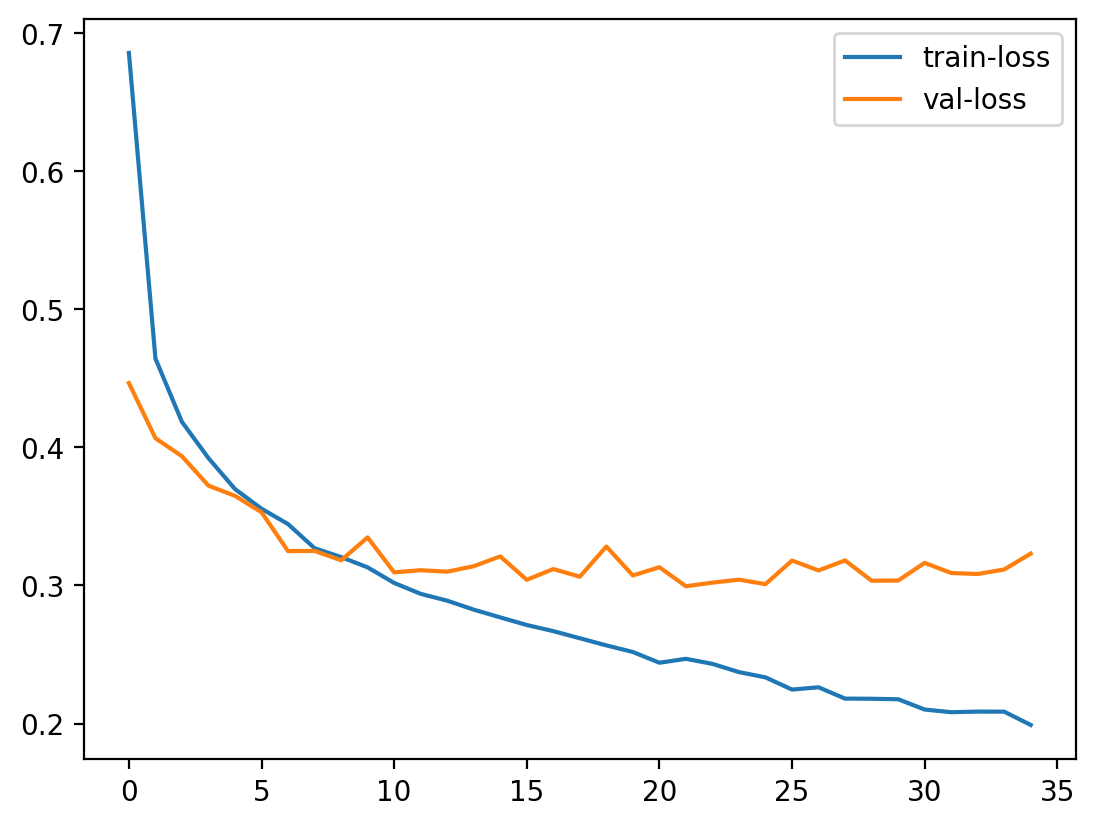

In [14]:
#Fitting the model to trainer
trainer.fit(model, dm)

# Train and validate again with new architecture
train_validate(model, n_epochs=35)

## Validate on test set

In [15]:
# Validate
trainer.test(model, datamodule=dm)

Accuracy: 88.65%
